# Getting Started with Chronos-2

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/amazon-science/chronos-forecasting/blob/main/notebooks/chronos-2-quickstart.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/amazon-science/chronos-forecasting/blob/main/notebooks/chronos-2-quickstart.ipynb)



**Chronos-2** is a foundation model for time series forecasting that builds on [Chronos](https://arxiv.org/abs/2403.07815) and [Chronos-Bolt](https://aws.amazon.com/blogs/machine-learning/fast-and-accurate-zero-shot-forecasting-with-chronos-bolt-and-autogluon/). It offers significant improvements in capabilities and can handle diverse forecasting scenarios not supported by earlier models.

| Capability | Chronos | Chronos-Bolt | Chronos-2 |
|------------|---------|--------------|-----------|
| Univariate Forecasting | ✅ | ✅ | ✅ |
| Cross-learning across items | ❌ | ❌ | ✅ |
| Multivariate Forecasting | ❌ | ❌ | ✅ |
| Past-only (real/categorical) covariates | ❌ | ❌ | ✅ |
| Known future (real/categorical) covariates | 🧩 | 🧩 | ✅ |
| Fine-tuning support | ✅ | ✅ | ✅ |
| Max. Context Length | 512 | 2048 | 8192 |

🧩 Chronos/Chronos-Bolt do not natively support future covariates, but they can be combined with external covariate regressors (see [AutoGluon tutorial](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html#incorporating-the-covariates)). This only models per-timestep effects, not effects across time. In contrast, Chronos-2 supports all covariate types natively.

More details about Chronos-2 are available in the [technical report](https://www.arxiv.org/abs/2510.15821).

In [1]:
# %pip install 'chronos-forecasting>=2.1' 'pandas[pyarrow]' 'matplotlib'

In [2]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("/root/autodl-tmp/TSFMs/pretrained/amazon/chronos-2", device_map="cuda")

## Univariate Forecasting

We start with a simple univariate forecasting example using the pandas API.

In [3]:
# Load data as a long-format pandas data frame
context_df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly/train.csv")
print("Input dataframe shape:", context_df.shape)
display(context_df.head())

Input dataframe shape: (353500, 3)


,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


In [4]:
pred_df = pipeline.predict_df(context_df, prediction_length=24, quantile_levels=[0.1, 0.5, 0.9])

print("Output dataframe shape:", pred_df.shape)
display(pred_df.head())

Output dataframe shape: (9936, 7)


,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,H1,1750-01-30 04:00:00,target,624.867981,611.385071,624.867981,638.598755
1,H1,1750-01-30 05:00:00,target,563.703125,546.655029,563.703125,578.665649
2,H1,1750-01-30 06:00:00,target,521.589844,505.747437,521.589844,537.950806
3,H1,1750-01-30 07:00:00,target,489.910706,473.671783,489.910706,508.854126
4,H1,1750-01-30 08:00:00,target,471.144440,452.199402,471.144440,491.050354


**predict_df** supports the following arguments:
- `df`: Long-format DataFrame with id, timestamp, and target column(s)
- `future_df`: Optional DataFrame with future covariates (columns present in both df and future_df are treated as known future covariates)
- `id_column`: Column with time series identifiers (default: "item_id")
- `timestamp_column`: Column with timestamps (default: "timestamp")
- `target`: Target column name(s) to forecast (default: "target")
- `prediction_length`: Number of steps to forecast
- `quantile_levels`: Quantiles to compute (default: [0.1, 0.2, ..., 0.9])

Returns a DataFrame with forecasts including point predictions and quantiles.

## Forecasting with Covariates

Chronos-2 can leverage covariates to improve forecast accuracy. We demonstrate this with two real-world examples.

### Energy Price Forecasting

Forecast hourly energy prices for the next day using historical prices and day-ahead forecasts of load (Ampirion Load Forecast) and renewable energy generation (PV+Wind Forecast).

In [5]:
# Energy price forecasting configuration
target = "target"  # Column name containing the values to forecast (energy prices)
prediction_length = 24  # Number of hours to forecast ahead
id_column = "id"  # Column identifying different time series (countries/regions)
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "DE"  # Specific time series to visualize (Germany)

# Load historical energy prices and past values of covariates
energy_context_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet"
)
display(energy_context_df.head())

# Load future values of covariates
energy_test_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/test.parquet"
)
energy_future_df = energy_test_df.drop(columns=target)
display(energy_future_df.head())

,id,timestamp,target,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2012-01-09 00:00:00,34.970001,16382.00,3569.527588
1,DE,2012-01-09 01:00:00,33.430000,15410.50,3315.274902
2,DE,2012-01-09 02:00:00,32.740002,15595.00,3107.307617
3,DE,2012-01-09 03:00:00,32.459999,16521.00,2944.620117
4,DE,2012-01-09 04:00:00,32.500000,17700.75,2897.149902


,id,timestamp,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2017-12-12 00:00:00,20483.00,22284.005859
1,DE,2017-12-12 01:00:00,19849.75,22878.673828
2,DE,2017-12-12 02:00:00,19638.25,23632.283203
3,DE,2017-12-12 03:00:00,19895.25,24635.945312
4,DE,2017-12-12 04:00:00,20338.00,25584.935547


In [6]:
# Generate predictions with covariates
energy_pred_df = pipeline.predict_df(
    energy_context_df,
    future_df=energy_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
display(energy_pred_df.head())

,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,DE,2017-12-12 00:00:00,target,22.242920,18.673721,22.242920,25.403452
1,DE,2017-12-12 01:00:00,target,19.525620,14.904282,19.525620,23.316601
2,DE,2017-12-12 02:00:00,target,17.415371,12.209061,17.415371,21.776978
3,DE,2017-12-12 03:00:00,target,16.979265,11.165121,16.979265,21.435223
4,DE,2017-12-12 04:00:00,target,18.058653,12.096769,18.058653,23.166641


In [7]:
# Visualization helper function
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

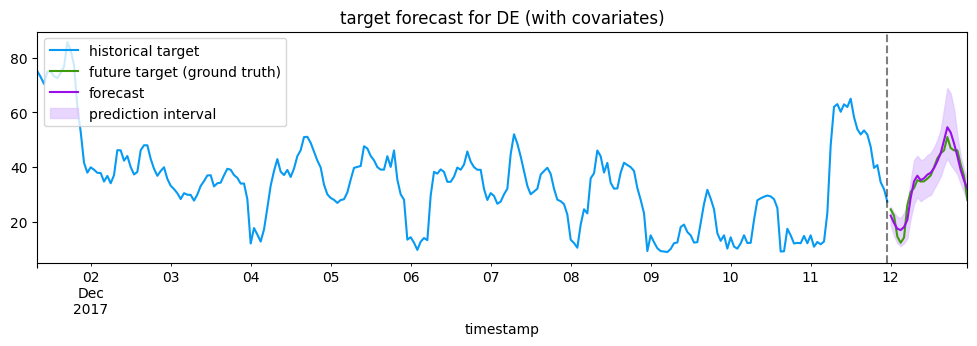

In [8]:
# Visualize forecast with covariates
plot_forecast(
    energy_context_df,
    energy_pred_df,
    energy_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)

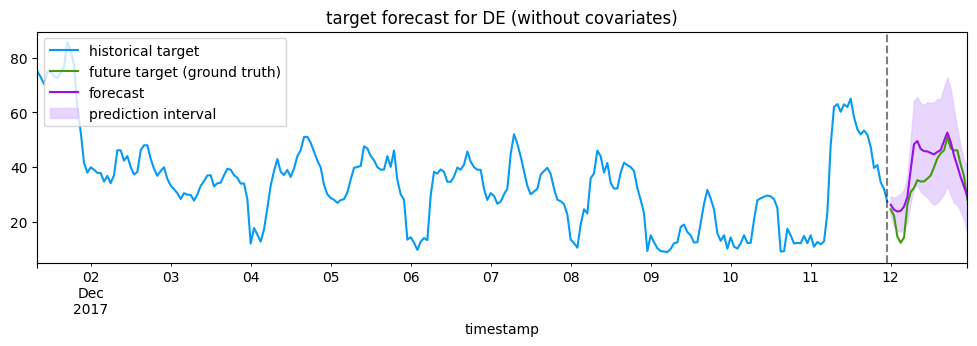

In [9]:
# Compare: forecast without covariates
energy_pred_no_cov_df = pipeline.predict_df(
    energy_context_df[[id_column, timestamp_column, target]],
    future_df=None,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)

plot_forecast(
    energy_context_df,
    energy_pred_no_cov_df,
    energy_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(without covariates)",
)

The comparison shows that Chronos-2 makes reasonable but imprecise predictions in univariate mode. However, with covariates, Chronos-2 effectively uses the load and renewable generation forecasts, producing significantly more accurate predictions.

### Retail Demand Forecasting

Forecast next quarter's weekly store sales using historical sales, historical customer footfall (Customers), and known covariates indicating store operation (Open), promotion periods (Promo), and holidays (SchoolHoliday, StateHoliday).

In [10]:
# Retail forecasting configuration
target = "Sales"  # Column name containing sales values to forecast
prediction_length = 13  # Number of days to forecast ahead
id_column = "id"  # Column identifying different products/stores
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "1"  # Specific time series to visualize (product/store ID)

# Load historical sales and past values of covariates
sales_context_df = pd.read_parquet("https://autogluon.s3.amazonaws.com/datasets/timeseries/retail_sales/train.parquet")
display(sales_context_df.head())

# Load future values of covariates
sales_test_df = pd.read_parquet("https://autogluon.s3.amazonaws.com/datasets/timeseries/retail_sales/test.parquet")
sales_future_df = sales_test_df.drop(columns=target)
display(sales_future_df.head())

,id,timestamp,Sales,Open,Promo,SchoolHoliday,StateHoliday,Customers
0,1,2013-01-13,32952.0,0.857143,0.714286,5.0,0.0,3918.0
1,1,2013-01-20,25978.0,0.857143,0.000000,0.0,0.0,3417.0
2,1,2013-01-27,33071.0,0.857143,0.714286,0.0,0.0,3862.0
3,1,2013-02-03,28693.0,0.857143,0.000000,0.0,0.0,3561.0
4,1,2013-02-10,35771.0,0.857143,0.714286,0.0,0.0,4094.0


,id,timestamp,Open,Promo,SchoolHoliday,StateHoliday
0,1,2015-05-03,0.714286,0.714286,0.0,1.0
1,1,2015-05-10,0.857143,0.714286,0.0,0.0
2,1,2015-05-17,0.714286,0.000000,0.0,1.0
3,1,2015-05-24,0.857143,0.714286,0.0,0.0
4,1,2015-05-31,0.714286,0.000000,0.0,1.0


In [11]:
# Generate predictions with covariates
sales_pred_df = pipeline.predict_df(
    sales_context_df,
    future_df=sales_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
    validate_inputs=False
)
display(sales_pred_df.head())

,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,1,2015-04-30,Sales,28939.394531,25214.275391,28939.394531,32411.097656
1,1,2015-05-07,Sales,25541.919922,21921.322266,25541.919922,29191.929688
2,1,2015-05-14,Sales,23640.238281,20500.335938,23640.238281,26884.666016
3,1,2015-05-21,Sales,26778.261719,23318.355469,26778.261719,30162.822266
4,1,2015-05-28,Sales,22679.361328,19722.285156,22679.361328,25990.042969


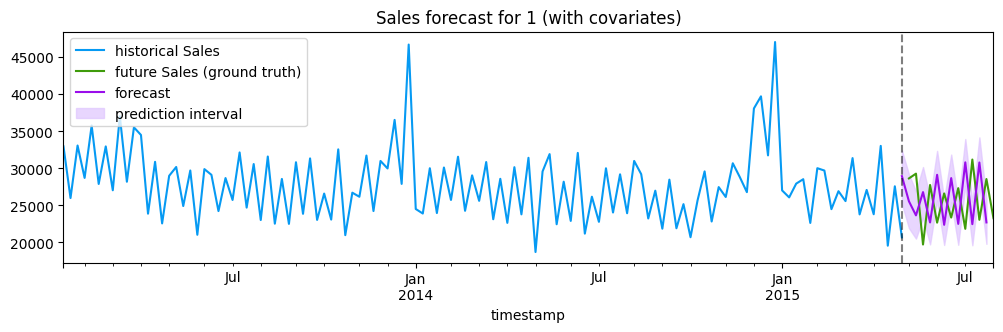

In [12]:
# Visualize forecast with covariates
plot_forecast(
    sales_context_df,
    sales_pred_df,
    sales_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)

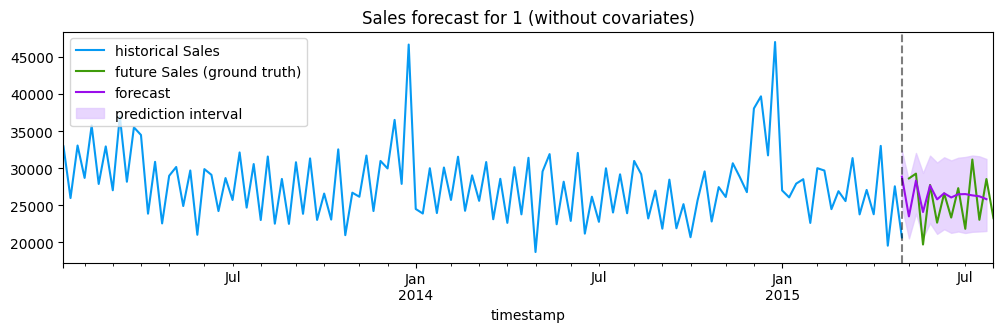

In [13]:
# Compare: forecast without covariates
sales_pred_no_cov_df = pipeline.predict_df(
    sales_context_df[[id_column, timestamp_column, target]],
    future_df=None,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)

plot_forecast(
    sales_context_df,
    sales_pred_no_cov_df,
    sales_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(without covariates)",
)

Chronos-2's univariate forecast is nearly flat with high uncertainty. In contrast, the forecast with covariates leverages promotion and holiday information to capture the true sales dynamics over the forecast horizon.

## Cross-Learning with Joint Prediction

Chronos-2 supports **cross-learning** through the `predict_batches_jointly=True` parameter, which enables the model to share information across all time series in a batch during prediction. This can be particularly beneficial when forecasting multiple related time series with short historical context.

In [14]:
# Example: Enable cross-learning for joint prediction
# This assigns the same group ID to all time series, allowing information sharing
joint_pred_df = pipeline.predict_df(
    context_df,
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    predict_batches_jointly=True,  # Enable cross-learning
    batch_size=100,
)

/root/miniconda3/envs/TSFMs/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: FutureWarning: The `predict_batches_jointly` argument is deprecated and will be removed in a future version. Please use `cross_learning=True` to enable the cross-learning mode.
  return func(*args, **kwargs)


### Important Considerations for Cross-Learning

When using `predict_batches_jointly=True`, keep these caveats in mind:

- **Task-dependent results**: Cross-learning may not always improve forecasts and could worsen performance for some tasks. Evaluate this feature for your specific use case.

- **Batch size dependency**: Results become dependent on batch size. Very large batch sizes may not provide benefits as they deviate from the maximum group size used during pretraining. For optimal results, consider using a batch size around 100 (as used in the paper).

- **Input homogeneity**: This feature works best with homogeneous inputs (e.g., multiple univariate time series of the same type). Mixing different task types may lead to unexpected behavior.

- **Short context benefit**: Cross-learning is most helpful when individual time series have limited historical context, as the model can leverage patterns from related series in the batch.

## (Advanced) Numpy/torch API

For advanced use cases, Chronos-2 provides a lower-level numpy/torch API via the `predict_quantiles` method.

The `predict_quantiles` method accepts:
- `inputs`: Time series to forecast (see formats below)
- `prediction_length`: Number of timesteps to forecast
- `quantile_levels`: List of quantiles to compute

Two input formats are supported:
1. **3D array**: `(batch_size, num_variates, history_length)` for forecasting without covariates
2. **List of dicts**: Each dict contains:
   - `target`: 1D or 2D array of shape `(history_length,)` or `(num_variates, history_length)`
   - `past_covariates` (optional): Dict mapping covariate names to 1D arrays of length `history_length`
   - `future_covariates` (optional): Dict mapping covariate names to 1D arrays of length `prediction_length`

In [15]:
# Univariate forecasting
inputs = np.random.randn(32, 1, 100)
quantiles, mean = pipeline.predict_quantiles(
    inputs, prediction_length=24, quantile_levels=[0.1, 0.5, 0.9]
)
print("Univariate output shapes:", quantiles[0].shape, mean[0].shape)

Univariate output shapes: torch.Size([1, 24, 3]) torch.Size([1, 24])


In [16]:
# Multivariate forecasting
inputs = np.random.randn(32, 3, 512)
quantiles, mean = pipeline.predict_quantiles(
    inputs, prediction_length=48, quantile_levels=[0.1, 0.5, 0.9]
)
print("Multivariate output shapes:", quantiles[0].shape, mean[0].shape)

Multivariate output shapes: torch.Size([3, 48, 3]) torch.Size([3, 48])


In [17]:
# Univariate forecasting with covariates
prediction_length = 64
inputs = [
    {
        "target": np.random.randn(200),
        "past_covariates": {"temperature": np.random.randn(200), "precipitation": np.random.randn(200)},
        "future_covariates": {"temperature": np.random.randn(prediction_length)},
    }
    for _ in range(16)
]
quantiles, mean = pipeline.predict_quantiles(
    inputs, prediction_length=prediction_length, quantile_levels=[0.1, 0.5, 0.9]
)
print("Univariate with covariates output shapes:", quantiles[0].shape, mean[0].shape)

Univariate with covariates output shapes: torch.Size([1, 64, 3]) torch.Size([1, 64])


In [18]:
# Multivariate forecasting with categorical covariates
prediction_length = 96
inputs = [
    {
        "target": np.random.randn(2, 1000),
        "past_covariates": {
            "temperature": np.random.randn(1000),
            "weather_type": np.random.choice(["sunny", "cloudy", "rainy"], size=1000),
        },
        "future_covariates": {
            "temperature": np.random.randn(prediction_length),
            "weather_type": np.random.choice(["sunny", "cloudy", "rainy"], size=prediction_length),
        },
    }
    for _ in range(10)
]
quantiles, mean = pipeline.predict_quantiles(
    inputs, prediction_length=prediction_length, quantile_levels=[0.1, 0.5, 0.9]
)
print("Multivariate with categorical covariates output shapes:", quantiles[0].shape, mean[0].shape)

Multivariate with categorical covariates output shapes: torch.Size([2, 96, 3]) torch.Size([2, 96])


## Fine-Tuning

Chronos-2 supports fine-tuning on your own data.

### Fine-Tuning API

The `fit` method accepts:
- `inputs`: Time series for fine-tuning (same format as predict_quantiles)
- `prediction_length`: Forecast horizon for fine-tuning
- `validation_inputs`: Optional validation data (same format as inputs)
- `learning_rate`: Optimizer learning rate (default: 1e-5)
- `num_steps`: Number of training steps (default: 1000)
- `batch_size`: Batch size for training (default: 256)

Returns a new pipeline with the fine-tuned model.

In [19]:
# Prepare data for fine-tuning using the retail sales dataset
known_covariates = ["Open", "Promo", "SchoolHoliday", "StateHoliday"]
past_covariates = ["Customers"]

train_inputs = []
for item_id, group in sales_context_df.groupby("id"):
    train_inputs.append({
        "target": group[target].values,
        "past_covariates": {col: group[col].values for col in past_covariates + known_covariates},
        # Future values of covariates are not used during training.
        # However, we need to include their names to indicate that these columns will be available at prediction time
        "future_covariates": {col: None for col in known_covariates},
    })

In [20]:
# Fine-tune the model
finetuned_pipeline = pipeline.fit(
    inputs=train_inputs,
    prediction_length=13,
    num_steps=50,  # few fine-tuning steps for a quick demo
    learning_rate=1e-5,
    batch_size=32,
    logging_steps=10,
)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,0.762000
20,0.803700
30,0.661800
40,0.719200
50,0.639500


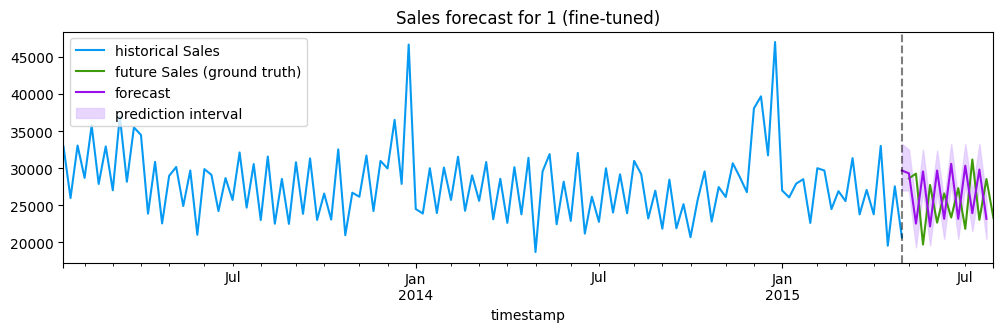

In [21]:
# Use the fine-tuned model for predictions
finetuned_pred_df = finetuned_pipeline.predict_df(
    sales_context_df,
    future_df=sales_future_df,
    prediction_length=13,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="id",
    timestamp_column="timestamp",
    target="Sales",
    validate_inputs=False
)

plot_forecast(
    sales_context_df,
    finetuned_pred_df,
    sales_test_df,
    target_column="Sales",
    timeseries_id="1",
    title_suffix="(fine-tuned)",
)

**Note:** Fine-tuning functionality is intended for advanced users. The default fine-tuning hyperparameters may not always improve accuracy for your specific use case. We recommend experimenting with different hyperparameters. 